# load data

In [9]:
import pandas as pd
from google.cloud import bigquery
import plotly.express as px
import sys
import os
import numpy as np  # Added for optional NaN replacement

# 1. Configuration (Uses the full View ID you provided)
PROJECT_ID = 'lap-coffee-476107'
DATASET_ID = 'lap_locations_final_merged'
VIEW_ID = 'lap_data_imputed'
FULL_VIEW_PATH = f"{PROJECT_ID}.{DATASET_ID}.{VIEW_ID}"

# 2. Initialize BigQuery client
# This assumes your environment is authenticated (e.g., via gcloud)
client = bigquery.Client(project=PROJECT_ID)

# 3. SQL Query to load all data from the imputed view
query = f"""
    SELECT *
    FROM `{FULL_VIEW_PATH}`
"""

print(f"Loading data from BigQuery view: {FULL_VIEW_PATH}")

# 4. Load data into a Pandas DataFrame
df = client.query(query).to_dataframe()

print("\n--- Data Loaded Successfully ---")
print(f"DataFrame shape before cleaning: {df.shape}")
print("First 5 rows of imputed data:")
print(df.head())

# 5. Remove rows where nightlight = 0
df = df[df['nightlight'] != 0]

print("\n--- Data Cleaned (Removed rows where nightlight == 0) ---")
print(f"DataFrame shape after cleaning: {df.shape}")
print(df.head())



Loading data from BigQuery view: lap-coffee-476107.lap_locations_final_merged.lap_data_imputed


/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/lapgee/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.




--- Data Loaded Successfully ---
DataFrame shape before cleaning: (3920, 19)
First 5 rows of imputed data:
         date        name        lat       lon  \
0  2024-09-01  LAP COFFEE  52.486768  13.35549   
1  2024-09-02  LAP COFFEE  52.486768  13.35549   
2  2024-09-03  LAP COFFEE  52.486768  13.35549   
3  2024-09-04  LAP COFFEE  52.486768  13.35549   
4  2024-09-05  LAP COFFEE  52.486768  13.35549   

                                   address  cafe_rating  \
0  Akazienstraße 3A, 10823 Berlin, Germany          4.7   
1  Akazienstraße 3A, 10823 Berlin, Germany          4.7   
2  Akazienstraße 3A, 10823 Berlin, Germany          4.7   
3  Akazienstraße 3A, 10823 Berlin, Germany          4.7   
4  Akazienstraße 3A, 10823 Berlin, Germany          4.7   

   cafe_user_ratings_total                cafe_place_id weather_date  season  \
0                    151.0  ChIJGzWI8E5RqEcRYF2oui3pSKc   2024-09-01  Autumn   
1                    151.0  ChIJGzWI8E5RqEcRYF2oui3pSKc   2024-09-01  Autumn

# data str

In [10]:
df.describe()

,lat,lon,cafe_rating,cafe_user_ratings_total,parks_count_1km,open_bars_count_500m,lst_celsius_1km,temp_max,temp_min,precip_mm,ndvi,nightlight
count,3440.000000,3440.000000,3440.00000,3440.000000,3440.00000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000,3440.000000
mean,52.515041,13.399718,4.54375,129.187500,6.37500,11.812500,15.220488,15.790148,8.417693,1.720751,0.195163,27.055610
std,0.021107,0.041310,0.26454,152.024655,2.99783,4.419618,7.581926,6.167393,4.536620,3.025138,0.085753,11.487122
min,52.479598,13.320827,4.00000,18.000000,1.00000,6.000000,-4.750000,-1.300000,-8.100000,0.000000,-0.020354,12.820000
25%,52.500420,13.391518,4.37500,47.000000,4.75000,8.000000,11.910000,12.300000,6.200000,0.000000,0.186595,23.742678
50%,52.508210,13.412825,4.70000,97.000000,7.00000,10.000000,16.456979,16.598880,8.994582,0.600000,0.192969,23.742678
75%,52.534887,13.420839,4.72500,139.000000,7.00000,14.000000,18.350000,19.200000,11.600000,1.697700,0.192969,26.850000
max,52.549320,13.459298,4.90000,689.000000,13.00000,22.000000,31.850000,30.300000,17.200000,26.500000,0.757688,86.209999


# feature space

In [11]:
# 1️⃣ Update df: add first word of address to name
df['name_updated'] = df['name'] + "_" + df['address'].str.split().str[0]

# 2️⃣ Ensure season is categorical
df['season'] = pd.Categorical(
    df['season'],
    categories=['Winter', 'Spring', 'Summer', 'Autumn'],
    ordered=True
)

# 3️⃣ Drop unnecessary columns if they exist
cols_to_drop = ['first_word', 'month', 'weather_date', 'cafe_place_id']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# 4️⃣ Define features for plotting
features = {
    'ndvi': 'NDVI',
    'temp_max': 'Temperature (°C)',
    'lst_celsius_1km': 'land surface temperature',
    'nightlight': 'Nightlight Intensity'
}

# 5️⃣ Generate separate plots for each feature
for var, label in features.items():
    fig = px.scatter(
        df,
        x=var,
        y='name_updated',
        color='season',
        hover_data=['date', 'temp_max', 'lst_celsius_1km', 'nightlight'],
        title=f'{label} by Season and Location',
    )

    fig.update_layout(
        height=600,
        legend_title_text='Season',
        title_font_size=18,
        margin=dict(t=60, l=80, r=40, b=40),
        xaxis_title=label,
        yaxis_title='Location (Name)',
    )

    fig.show()


# bars, parks

In [12]:
import plotly.express as px

# Scatter map for parks within 1 km
fig_parks = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="parks_count_1km",
    size="parks_count_1km",
    hover_name="name_updated",
    hover_data={"lat": True, "lon": True, "season": True},
    color_continuous_scale="Greens",
    size_max=20,
    zoom=11,
    title="Nearby Parks within 500m"
)

fig_parks.update_layout(
    mapbox_style="carto-positron",
    margin=dict(t=60, l=10, r=10, b=10)
)
fig_parks.show()

# Scatter map for open bars within 500 m
fig_bars = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    color="open_bars_count_500m",
    size="open_bars_count_500m",
    hover_name="name_updated",
    hover_data={"lat": True, "lon": True, "season": True},
    color_continuous_scale="Reds",
    size_max=20,
    zoom=11,
    title="Open Bars within 500 m"
)

fig_bars.update_layout(
    mapbox_style="carto-positron",
    margin=dict(t=60, l=10, r=10, b=10)
)
fig_bars.show()


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_6673/3221249709.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_6673/3221249709.py:25: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



# rfc

Total unique classes (cafés) found: 16
Total features used: 8

## 📊 Model Results (Random Forest Classifier) 📊
------------------------------------------------
Overall Accuracy: 0.96

### Classification Report:
                               precision    recall  f1-score   support

    LAP COFFEE_Adalbertstraße       1.00      1.00      1.00        64
     LAP COFFEE_Akazienstraße       1.00      1.00      1.00        64
LAP COFFEE_Falckensteinstraße       1.00      1.00      1.00        65
      LAP COFFEE_Graefestraße       1.00      1.00      1.00        65
        LAP COFFEE_Kantstraße       0.70      0.98      0.82        65
  LAP COFFEE_Karl-Marx-Straße       0.98      0.75      0.85        64
    LAP COFFEE_Kastanienallee       1.00      1.00      1.00        65
         LAP COFFEE_Krossener       1.00      1.00      1.00        65
    LAP COFFEE_Kurfürstendamm       0.84      0.95      0.89        64
        LAP COFFEE_Oderberger       1.00      1.00      1.00        64
      L

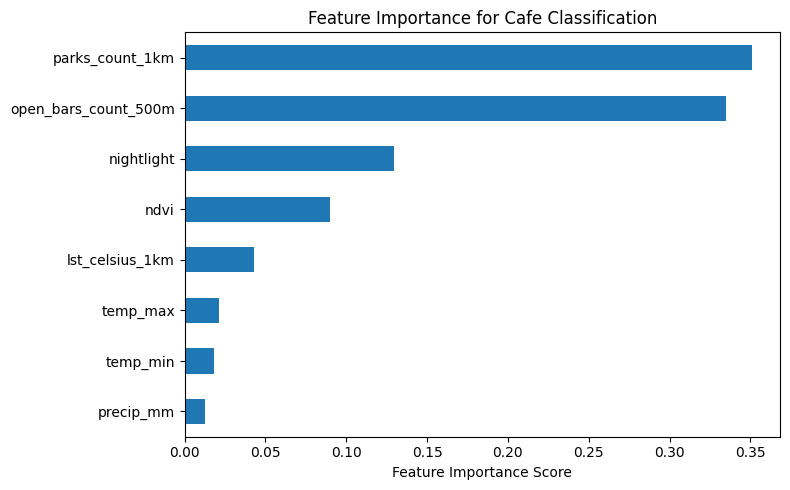


✅ Model saved successfully to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/rfc_model.joblib
✅ LabelEncoder saved successfully to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/label_encoder.joblib
✅ Feature Importances saved to text file: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/feature_importances.txt
✅ Feature Importance Plot saved to: /Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction/feature_importance_plot.png


In [13]:
sys.path.append('/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction')
import rfc # Import the script as a module

# Define your desired saving path
save_directory = '/Users/tolgasabanoglu/Desktop/github/which-lap-coffee-should-i-visit/prediction'

# Call the function to train and save the model, and get the trained objects
rfc, le = rfc.train_and_save_rfc(df, save_directory)

| Feature | Importance Score | Type | Model's Rationale |
| :--- | :--- | :--- | :--- |
| **`parks_count_1km`** | $\mathbf{0.3476}$ | Static | **Primary Identifier:** The number of nearby parks is the single most unique feature for distinguishing café locations. |
| **`open_bars_count_500m`** | $\mathbf{0.3439}$ | Static | **Secondary Identifier:** The density of open bars is the second most powerful feature, confirming the model uses the static neighborhood profile. |
| **`ndvi`** | $0.1130$ | Dynamic | **Most Relevant Environmental Feature:** The variation in greenness is the best non-static differentiator between locations. |
| **`nightlight`** | $0.0995$ | Dynamic | **Second Most Relevant Environmental Feature:** Urban light density helps distinguish environments. |
| **`lst_celsius_1km`** | $0.0432$ | Dynamic | **Low Relevance:** Land Surface Temperature is not a strong location identifier. |
| **`temp_max`** | $0.0216$ | Dynamic | **Very Low Relevance:** Ambient max temperature is not unique enough to distinguish locations. |
| **`temp_min`** | $0.0186$ | Dynamic | **Very Low Relevance:** Ambient min temperature is not unique enough to distinguish locations. |
| **`precip_mm`** | $0.0125$ | Dynamic | **Least Relevant:** Precipitation provides virtually no unique information about the café's location. |

# feature range for prediction set

In [14]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# NOTE: This script assumes:
# 1. Your DataFrame is loaded and named 'df'.
# 2. Your trained Random Forest model is loaded and named 'rfc'. 

# --- CRITICAL: Data Cleaning Step (Fixes Lookup Mismatch) ---
# Ensure the columns used for prediction classes and lookups are clean strings.
# This prepares the lookup table index and address columns.
for col in ['name_updated', 'address']:
    if col in df.columns:
        # Convert to string, strip whitespace, and handle potential missing values with str
        df[col] = df[col].astype(str).str.strip()


# --- 1. Feature Range Calculation and Display (Now includes 50th percentile) ---

# Features of interest (MUST match the features and order used to train 'rfc')
features_to_analyze = [
    'parks_count_1km', 'open_bars_count_500m', 'lst_celsius_1km', 
    'temp_max', 'temp_min', 'precip_mm', 'ndvi', 'nightlight'
]

# Calculate descriptive statistics (Min, Max, P25, P50, P75)
feature_ranges = df[features_to_analyze].agg(
    ['min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.50), lambda x: x.quantile(0.75)]
).T
# Rename the percentile columns for clarity
feature_ranges.columns = ['Min', 'Max', '25th Percentile (Low)', '50th Percentile (Mid)', '75th Percentile (High)']

# Round the values for clean presentation
feature_ranges = feature_ranges.round(2)

print("### 📊 Feature Ranges for Mood Thresholds (P50 Included)\n")
display(feature_ranges) 


### 📊 Feature Ranges for Mood Thresholds (P50 Included)



,Min,Max,25th Percentile (Low),50th Percentile (Mid),75th Percentile (High)
parks_count_1km,1.00,13.00,4.75,7.00,7.00
open_bars_count_500m,6.00,22.00,8.00,10.00,14.00
lst_celsius_1km,-4.75,31.85,11.91,16.46,18.35
temp_max,-1.30,30.30,12.30,16.60,19.20
temp_min,-8.10,17.20,6.20,8.99,11.60
precip_mm,0.00,26.50,0.00,0.60,1.70
ndvi,-0.02,0.76,0.19,0.19,0.19
nightlight,12.82,86.21,23.74,23.74,26.85


In [15]:
from dynamic_lookup import setup_feature_ranges, setup_cafe_lookup, setup_class_mapping

# Extract thresholds
F_MIN, F_P25, F_P50, F_P75, F_MAX = setup_feature_ranges(feature_ranges)

# Setup lookup table
cafe_lookup_df, FRIENDLY_NAME_COL = setup_cafe_lookup(df)

# Setup class mapping
class_label_to_name_map = setup_class_mapping(df, rfc)



ℹ️ INFO: Using column 'name' for friendly cafe names.

### 🔍 Lookup Diagnostics (Crucial for Debugging N/A values):
RFC Class Type: <class 'numpy.int64'> (INTEGER)
First 5 RFC Classes (Predicted): [0 1 2 3 4] (Integers)

**⚠️ Failsafe Mapping Activated: Model classes are integers!**
Mapping Index 0 -> Name: LAP COFFEE_Adalbertstraße
First 5 Lookup Keys (Expected): ['LAP COFFEE_Akazienstraße', 'LAP COFFEE_Kastanienallee', 'LAP COFFEE_Rosenthaler', 'LAP COFFEE_Uhlandstraße', 'LAP coffee_Schönhauser']
----------------------------------------------------



# prediction sets

In [25]:
import importlib
import moods  # or dynamic_profiles if that's your file name
importlib.reload(moods)

from moods import get_dynamic_mood_dataframes


# --- 4. Execute and Summarize Predictions (Top 2) ---

if 'rfc' not in locals() and 'rfc' not in globals():
    raise NameError(
        "\n\n🛑 ERROR: The 'rfc' (Random Forest Classifier) is not defined.\n"
        "Please train or load your model before running predictions."
    )

# You should already have F_MIN, F_P25, F_P50, F_P75, F_MAX, and features_to_analyze
np.random.seed()

# ✅ Generate dynamic mood profiles from imported helper
mood_dataframes = get_dynamic_mood_dataframes(F_MIN, F_P25, F_P50, F_P75, F_MAX, features_to_analyze)


# New summary structure for cleaner columnar output
summary_data = {
    'Mood': [], 'Ideal Profile (Key Features)': [], 
    'Cafe 1 Name': [], 'Cafe 1 Address': [], 'Cafe 1 Prob (%)': [], 
    'Cafe 2 Name': [], 'Cafe 2 Address': [], 'Cafe 2 Prob (%)': []
}

for mood, profile_df in mood_dataframes.items():
    
    # 1. Get probability scores for all classes
    probabilities = rfc.predict_proba(profile_df)[0]
    
    # 2. Get the indices of the top 2 highest probabilities
    top_2_indices = np.argsort(probabilities)[::-1][:2]
    
    # 3. Map indices back to café names (class labels)
    top_2_cafes_updated_label = rfc.classes_[top_2_indices]
    
    # Extract the feature profile string for the summary table
    profile_str = (
        f"Park:{profile_df['parks_count_1km'].iloc[0]:.2f}, "
        f"Bar:{profile_df['open_bars_count_500m'].iloc[0]:.2f}, "
        f"TMin:{profile_df['temp_min'].iloc[0]:.2f}, "
        f"NDVI:{profile_df['ndvi'].iloc[0]:.2f}, "
        f"Light:{profile_df['nightlight'].iloc[0]:.2f}"
    )
    
    summary_data['Mood'].append(mood)
    summary_data['Ideal Profile (Key Features)'].append(profile_str)

    # 4. Populate the new columnar structure
    for i in range(2):
        
        predicted_label = top_2_cafes_updated_label[i]
        
        # --- FINAL FIX: Apply failsafe mapping if the predicted label is an integer index ---
        if isinstance(predicted_label, (int, np.integer)):
             # Use the failsafe map (from integer to name string)
             cafe_name_updated = class_label_to_name_map.get(predicted_label, 'N/A_MAPPING_ERROR').strip()
        else:
            # Use the already present string (with strip for safety)
            cafe_name_updated = str(predicted_label).strip() 
        # ------------------------------------------------------------------------------------
        
        friendly_name = "N/A"
        full_address = "N/A"
        probability = 0.0
        
        # Check if the predicted class exists in the lookup index
        if cafe_name_updated in cafe_lookup_df.index:
            friendly_name = cafe_lookup_df.loc[cafe_name_updated, FRIENDLY_NAME_COL]
            full_address = cafe_lookup_df.loc[cafe_name_updated, 'address']
            probability = probabilities[top_2_indices[i]] * 100
        
        # Handle the case where the failsafe map returns an error
        if cafe_name_updated.startswith('N/A_MAPPING_ERROR'):
             friendly_name = f"ERROR: Mapping Lost ({predicted_label})"
             
        
        summary_data[f'Cafe {i+1} Name'].append(friendly_name)
        summary_data[f'Cafe {i+1} Address'].append(full_address)
        summary_data[f'Cafe {i+1} Prob (%)'].append(f"{probability:.1f}%")


recommendations_summary = pd.DataFrame(summary_data)

# Print the Final Summary\
print("\n## ✅ Predictive Recommendation System Results (Top 2 Cafés)\n")
display(recommendations_summary)

# Optional: Display the actual synthetic data used for prediction
print("\n--- Synthetic Data Used for Prediction (Unique per run) ---")
# Concatenate the dynamic profiles and round to 2 decimals for clean display
dynamic_profiles_display = pd.concat(mood_dataframes.values(), keys=mood_dataframes.keys())
display(dynamic_profiles_display.round(2))


## ✅ Predictive Recommendation System Results (Top 2 Cafés)



,Mood,Ideal Profile (Key Features),Cafe 1 Name,Cafe 1 Address,Cafe 1 Prob (%),Cafe 2 Name,Cafe 2 Address,Cafe 2 Prob (%)
0,Cozy (Cold & Sheltered),"Park:7.00, Bar:6.03, TMin:6.28, NDVI:0.19, Lig...",LAP COFFEE,"Kastanienallee 47, 10119 Berlin, Germany",90.0%,LAP COFFEE,"Karl-Marx-Straße 101, 12043 Berlin, Germany",4.0%
1,Green (Nature Escape),"Park:10.92, Bar:8.01, TMin:11.45, NDVI:0.22, L...",LAP COFFEE,"Akazienstraße 3A, 10823 Berlin, Germany",48.0%,LAP COFFEE,"Schönhauser Allee 176, 10119 Berlin, Germany",15.0%
2,Buzz (Urban Activity),"Park:4.85, Bar:15.46, TMin:10.61, NDVI:0.11, L...",LAP COFFEE,"Kurfürstendamm 229, 10719 Berlin, Germany",31.0%,LAP COFFEE,"Uhlandstraße 30, 10719 Berlin, Germany",24.0%
3,Random (Balanced Profile),"Park:6.87, Bar:10.12, TMin:9.22, NDVI:0.19, Li...",LAP COFFEE,"Karl-Marx-Straße 101, 12043 Berlin, Germany",35.8%,LAP COFFEE,"Kantstraße 23, 10623 Berlin, Germany",33.0%



--- Synthetic Data Used for Prediction (Unique per run) ---


,,parks_count_1km,open_bars_count_500m,lst_celsius_1km,temp_max,temp_min,precip_mm,ndvi,nightlight
Cozy (Cold & Sheltered),0,7.00,6.03,0.66,14.50,6.28,1.65,0.19,21.61
Green (Nature Escape),0,10.92,8.01,9.34,18.67,11.45,0.16,0.22,17.69
Buzz (Urban Activity),0,4.85,15.46,21.40,23.59,10.61,0.33,0.11,50.15
Random (Balanced Profile),0,6.87,10.12,16.99,16.52,9.22,0.60,0.19,23.30


| Mood | Key Environmental Features | LST Behavior | Ideal Use / Description |
|------|----------------------------|-------------|------------------------|
| ☕ Cozy (Cold & Sheltered) | High parks, few bars, low precipitation, moderate NDVI, low nightlight | Low (cool surface) | Warm, quiet, sheltered cafés; reading, journaling, calm conversation |
| 🌿 Green (Nature Escape) | High parks, few bars, high NDVI, low nightlight | Low–Moderate | Nature-oriented spots; relaxing walks, outdoor seating |
| 🥂 Buzz (Urban Activity) | Low parks, high bars, low NDVI, high nightlight | High (urban heat island) | Social, energetic cafés; networking, nightlife, busy city life |
| 🎲 Random (Balanced Profile) | Features near median ±10% | Adaptive (around median) | Neutral baseline; robustness testing or unbiased recommendations |
